In [1]:
import datetime
import math
import pandas as pd
from IPython.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta
from scipy import stats
from scipy.stats import chi2, chi2_contingency
import random
import os

for more information pls check gitHub reporsitory: https://github.com/caglanakpinar/a_b_test

In [2]:
date_start = '2019-08-05' # this the day that my sample ab_tesitng data sset is started.
is_from_db = False # Normally, this notebook runs from my local postgre sql db. 
# However, I also attached the .csv file of each data frame and zip them

# In order to run sample data sets, make sure unzip ab.test_data.csv
# This data is randomly created. It is not related to any companies or web sites. For more infırmation about how randomly it creates, you may check a_b_test_data_creator.ipnb

### Problem Defination
- I want to make a improvement on my web page. I wonder that how this development effect my clients attributes.
#### Main Question; is the any difference between each screen of attractions?
- In order to answer this question I will sample from 

### Data I need?
- I need binary transaction for each client of visits. It must be well splited into Control and Validation Sets.
- Control and Validation sets of sample size can be equal if it is possible.
- In orer to sample, for each variation I use RAndom Sampling. 
- However, I segmented clients list, in each cluster of my client data set, randomly I picked my data sets.
- In order to find the right sample size for each segment. This calculation will worked well;
### segment_sample_size_control =  (segment_client_count/ total_client_count) * total_control_sample_size
- Segmentation is another problem, but I have already segmented my clients by RFM segmentation.
- I am going to calculate for whole sample of Control and Validation Sets, also, I will calculate my CTR values for each RFM segmets too.
- After I have sampled my data, I will calculate the Click Through Rate for each metrics which are login, basket, login_screen, ordered for Control and Validation samples.
- CTR_login = login_count / session_count
- CTR_basket = basket_count / session_count
- CTR_basket = order_screen_count / session_count
- CTR_basket = order_count / session_count



# Data Access

- The data set has clients of transactions.
- Sample data set has two variation of a web site. It also has the clients of attributes after they see two variation.
#### Metrics of check are; 
##### login: 
- It shows client sign in after seeing the screen in their visits. (0: Not Signing in (Not click) , 1: Signing in (click))
##### basket: 
- It shows adding any product to thier basket in visits after they sign in (0: Didn`t add anything in basket, 1: There is a basket (click)) 
##### order_screen: 
- It shows being at payment screen after they add any products to thier baskets in their visits. (0: didn`t visit payment screen, 1: visited payment screen (click))
##### order_count:
- It shows ordering action of each transaction of client after their visits. (0: not ordered, 1: ordered (click))

In [3]:
if is_from_db:
    query = """
            SELECT
                client_id,
                is_control,
                sum(CASE WHEN session IS NOT NULL THEN 1 ELSE 0 END) as session_count,
                sum(CASE WHEN login IS NOT NULL THEN 1 ELSE 0 END) as login_count,
                sum(CASE WHEN basket IS NOT NULL THEN 1 ELSE 0 END) as basket_count,
                sum(CASE WHEN order_screen IS NOT NULL THEN 1 ELSE 0 END) as order_screen_count,
                sum(CASE WHEN ordered IS NOT NULL THEN 1 ELSE 0 END) as order_count
            
            FROM designingtest WHERE date = '{}'
            GROUP BY client_id, is_control
    """.format(str(date_start)[0:10])
    ab_test = pd.read_sql(query, connection_abtestdb)    
else:
    ab_test = pd.read_csv("ab_test_start_date.csv")  
ab_test.head(1)

Unnamed: 0 client_id  is_control  session_count  login_count  basket_count  \
0           0   8060_id           0              1            0             0   

   order_screen_count  order_count  
0                   0            0

In [4]:
if is_from_db:
    query = """
            SELECT frequency_segment, monetary_segment, recency_segment, client_id
            FROM client_segments_daily WHERE date = '{}'
    """.format(str(datetime.datetime.strptime(date_start, '%Y-%m-%d') + datetime.timedelta(days=2))[0:10])
    segments = pd.read_sql(query, connection_clientsdb)
else:
    segments = pd.read_csv("segments.csv") 
display(segments.head(1))

Unnamed: 0  frequency_segment  monetary_segment  recency_segment client_id
0           0                  1                 2                2  18440_id

In [5]:
ab_test = pd.merge(ab_test, segments, on='client_id', how='left')
ab_test['rfm'] = ab_test.apply(lambda row: 
                               str(row['recency_segment']) + '_' + 
                               str(row['frequency_segment']) + '_' + str(row['monetary_segment']) ,axis=1)
ab_test.head()

Unnamed: 0_x client_id  is_control  session_count  login_count  \
0             0   8060_id           0              1            0   
1             1   2837_id           0              1            0   
2             2   3476_id           1              1            0   
3             3   9607_id           0              1            0   
4             4   3350_id           0              1            0   

   basket_count  order_screen_count  order_count  Unnamed: 0_y  \
0             0                   0            0         14723   
1             0                   0            0          8158   
2             0                   0            0          4952   
3             0                   0            0          3532   
4             0                   0            0          2098   

   frequency_segment  monetary_segment  recency_segment    rfm  
0                  1                 4                1  1_1_4  
1                  1                 4                1  1_1_4  
2                  1                 4                1  1_1_4  
3                  1                 4                2  2_1_4  
4                  1                 4                1  1_1_4

In [6]:
print('list of RFM segments :')
list(ab_test['rfm'].unique())

list of RFM segments :


['1_1_4',
 '2_1_4',
 '2_1_2',
 '2_1_3',
 '3_4_1',
 '3_2_2',
 '3_3_1',
 '3_3_2',
 '1_1_3',
 '2_2_2',
 '4_4_1',
 '2_2_3',
 '3_2_3',
 '3_1_2',
 '3_2_1',
 '3_4_2',
 '3_1_3']

# A / B Test - Frequentist Approach
## Two Sample t- test:
- t Test allows us to answer the main question 'is the any difference between each screens of attractions?'
- Two sample t-test of confidence interval will show us how accuratelly new variation of screen worked. Two sample are Control VS Validation
- I will decided to implement my test with significance level of % 95.
- By accepting significance level of % 95, we also assume that %5 of error by H0 hyphothesis.
- In t - test we will work, We assume that CTR values will have t-distribution with estimated parameters X_mean and Standart Deviations of each control and Validation Sample.
- CTR ~ t(X_mean, Variance)

### Estimated Parameters 
- In roder to calculate t value for t-test, we need estimated parameters. 
- Beacuse we don`t know the population we are working on the sample of it which we assume that it represents it.
#### In this problem CTR values are paremters for t- distributions.


#### Let`s calcualte parameters (CTR values fo each metrics for each segments);

In [7]:
# I will calculate CTR values for each segment and client.
# Later, in order to calculate main data sets of CTR values, calculating the avreage of them will help me to find the CTR_main.
ab_test_pivot = ab_test.pivot_table(index=['rfm', 'is_control'], aggfunc={'session_count':'sum',
                                                                    'login_count':'sum',
                                                                   'basket_count':'sum',
                                                                   'order_screen_count':'sum',
                                                                   'order_count':'sum'}).reset_index()
# CTR_login = login_ratio
ab_test_pivot['login_ratio'] = ab_test_pivot['login_count'] / ab_test_pivot['session_count']
# CTR_basket = basket_ratio
ab_test_pivot['basket_ratio'] = ab_test_pivot['basket_count'] / ab_test_pivot['session_count']
# CTR_order_screen = order_screen_ratio
ab_test_pivot['order_screen_ratio'] = ab_test_pivot['order_screen_count'] / ab_test_pivot['session_count']
# CTR_order = order_ratio
ab_test_pivot['order_ratio'] = ab_test_pivot['order_count'] / ab_test_pivot['session_count']
ab_test_pivot = ab_test_pivot.reset_index()
ab_test_pivot.head()

index    rfm  is_control  basket_count  login_count  order_count  \
0      0  1_1_3           0            11           24            3   
1      1  1_1_3           1            21           43            2   
2      2  1_1_4           0           260          827           38   
3      3  1_1_4           1          1140         2919          288   
4      4  2_1_2           0            43          103            5   

   order_screen_count  session_count  login_ratio  basket_ratio  \
0                   8            104     0.230769      0.105769   
1                   9             95     0.452632      0.221053   
2                  94           4834     0.171080      0.053786   
3                 611           4846     0.602352      0.235246   
4                  25            245     0.420408      0.175510   

   order_screen_ratio  order_ratio  
0            0.076923     0.028846  
1            0.094737     0.021053  
2            0.019446     0.007861  
3            0.126083     0.059430  
4            0.102041     0.020408

### Let`s see how Control and Validation set of CTR values are distributedon each metrics

login_ratio  Check:
CTR (Parameters for t - distribution) Preditor of Control and Validation Group :
CTR_Control_login_ratio : 0.33  ||  CTR_Validation_login_ratio : 0.41


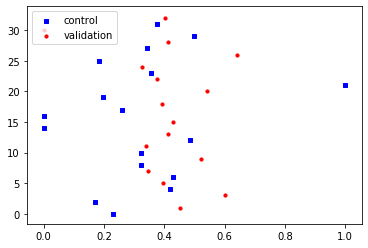

basket_ratio  Check:
CTR (Parameters for t - distribution) Preditor of Control and Validation Group :
CTR_Control_basket_ratio : 0.15  ||  CTR_Validation_basket_ratio : 0.17


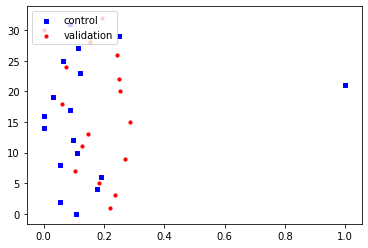

order_screen_ratio  Check:
CTR (Parameters for t - distribution) Preditor of Control and Validation Group :
CTR_Control_order_screen_ratio : 0.03  ||  CTR_Validation_order_screen_ratio : 0.08


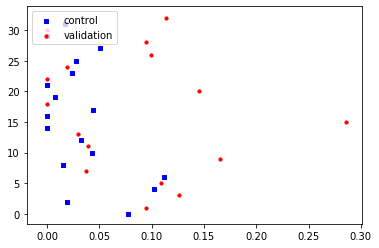

order_ratio  Check:
CTR (Parameters for t - distribution) Preditor of Control and Validation Group :
CTR_Control_order_ratio : 0.01  ||  CTR_Validation_order_ratio : 0.04


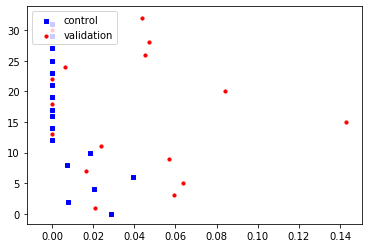

In [8]:
for i in ['login_ratio', 'basket_ratio', 'order_screen_ratio', 'order_ratio']:
    print(i, " Check:")
    x1 = ab_test_pivot[ab_test_pivot['is_control'] == 0][i].values
    y1 = ab_test_pivot[ab_test_pivot['is_control'] == 0]['index'].values
    x2 = ab_test_pivot[ab_test_pivot['is_control'] == 1][i].values
    y2 = ab_test_pivot[ab_test_pivot['is_control'] == 1]['index'].values
    print('CTR (Parameters for t - distribution) Preditor of Control and Validation Group :')
    print("CTR_Control_" + i + " :", round(np.mean(x1), 2), " || ", "CTR_Validation_" + i + " :", round(np.mean(x2), 2))
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.scatter(x1, y1, s=10, c='b', marker="s", label='control')
    ax1.scatter(x2,y2, s=10, c='r', marker="o", label='validation')
    plt.legend(loc='upper left');
    plt.show()

# Let`s calculate the t - tests of each metrics

### H0: There is no difference on control and validation test sets.
### H1: Thre statistically difference between Control And Validation sets of click ratios

In [11]:
# This is calculation of t value for t- distribution
def calculate_t_test(p1, p2, click1, click2, n1, n2):
    p = (click1 + click2) / (n1 + n2)
    t = (p1 - p2) / sqrt(( p * (1 - p)) / ((1 / n1) + (1 / n2)) )
    df = n1 + n2 - 2
    pval = 1 - stats.t.sf(np.abs(t), df)*2  # two-sided pvalue = Prob(abs(t)>tt)
    confidence_limit = 1.96 * sqrt(((p1 * (1 - p1)) / n1) + ((p2 * (1 - p2)) / n2))
    confidence_intervals = [abs(p1 - p2) - confidence_limit, abs(p1 - p2) + confidence_limit]
    return pval, confidence_intervals

In [12]:
metrics = ['login_count', 'basket_count', 'order_screen_count', 'order_count']
n1 = sum(list(ab_test_pivot[ab_test_pivot['is_control'] == 0]['session_count']))
n2 = sum(list(ab_test_pivot[ab_test_pivot['is_control'] == 1]['session_count']))

for metric in metrics:
    print("----- ", i, " Check :", "-----")
    print("H0 : There is no difference on control and validation test sets on ", metric, " ratios.")
    print("p_control_", metric, " = ", "p_validation_", metric)
    print("H1: Thre statistically difference between Control And Validation sets ", metric, " ratios.")
    print("p_control_", metric, " != ", "p_validation_", metric)
    print()
    click1 =  sum(list(ab_test_pivot[ab_test_pivot['is_control'] == 1][metric]))
    click2 =  sum(list(ab_test_pivot[ab_test_pivot['is_control'] == 0][metric]))
    print("Click Control :",  click1, " || \n Click Validation :",  click2, 
          " || \n Sample Size Control :", n1, " || \n Sample Size Validation :", n2)
    print()
    pval, confidence_intervals = calculate_t_test(click1 / n1, click2 / n2, click1, click2, n1, n2)
    print("p - value :", round(1- pval, 2), " || \n",
          "Control_CTR_" + metric + " :", round(click1 / n1, 2), " || \n",
          "Validation_CTR_" + metric + " :", round(click2 / n2, 2), " || \n",
          "-- HO REJECTED! --" if 1 - pval > 0.975 or 1 - pval < 0.25 else "-- HO ACCEPTED! --")
    print("left - right tail :", confidence_intervals)
    print()
    
    

-----  order_ratio  Check : -----
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count

Click Control : 4517  || 
 Click Validation : 2114  || 
 Sample Size Control : 8241  || 
 Sample Size Validation : 8890

p - value : 0.99  || 
 Control_CTR_login_count : 0.55  || 
 Validation_CTR_login_count : 0.24  || 
 -- HO REJECTED! --
left - right tail : [0.2963972417924672, 0.3242383931688889]

-----  order_ratio  Check : -----
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count

Click Control : 1761  || 
 Click Validation : 

### Result:
- Assumption of H0 is rejeceted for each metrics. There is significant difference between Control and Validation CTR statistically.

### T - Test Result Of Confidence;
- T test is a parametric test that needs estimeted paramters of data. In this problem our paramter is CTR which represents p ratios.
- However, t - test gives us a very general results of similarities between Control and Validation CTR`s, It is better to test the diffrence and similarities between Control and VAlidation set without using CTR parameter.
- In this case, It is  better to use one of the non-parametric test which is Chi_Square.

# Let`s see with Chi-Squared Test"

- t test is a test which runs with parameter of p proportion. 
- However, most of the time we don`t know the exact estimated p proportion.
- That is why, it is better to test also with Non Parametrics Test.
- Proportion of distributions are Chi-Squared. 
- This test is also one tail test. It is also convient to our data set.

In [13]:
# In order to valvulate Chi-Squared value for Chi-Square distribution,
# I need click and non click count of control and Validation sets.
def chi_square_test(total_control, click_control, total_validation, click_validation):
    observed_df = pd.DataFrame([
                    {'test': 'control', 'click': click_control, 'non_click': total_control - click_control},
                    {'test': 'validation', 'click': click_validation, 'non_click': total_control - click_validation},
                    {'test': 'total', 'click': click_control + click_validation, 
                     'non_click': (total_control - click_control) + (total_control - click_validation)},
                  ])
    observed_df['total'] = observed_df['click'] + observed_df['non_click']
    
    total = list(observed_df[observed_df['test'] == 'total']['total'])[0]
    
    x2_val = 0
    for g in ['control', 'validation']:
        for v in ['click', 'non_click']:
            _expected = (list(observed_df[observed_df['test'] == g]['total'])[0] * 
                         list(observed_df[observed_df['test'] == 'total'][v])[0]) / total
            _observed = list(observed_df[observed_df['test'] == g][v])[0]
            
            #print(_expected, _observed, pow((_observed - _expected), 2) / _expected)
            x2_val += pow((_observed - _expected), 2) / _expected
    pval = chi2.cdf(x=x2_val, df=1)
    print(pval, "HO REJECTED!" if pval > 0.95 else "HO ACCEPTED!")
    return [pval, "HO REJECTED!" if pval > 0.95 else "HO ACCEPTED!"]

# let`s run the each metric of Chi - Squared Test

In [14]:
metrics = ['login_count', 'basket_count', 'order_screen_count', 'order_count']
n1 = sum(list(ab_test[ab_test['is_control'] == 0]['session_count']))
n2 = sum(list(ab_test[ab_test['is_control'] == 1]['session_count']))

for metric in metrics:
    print(metric, " Check:")
    print("H0 : There is no difference on control and validation test sets on ", metric, " ratios.")
    print("p_control_", metric, " = ", "p_validation_", metric)
    print("H1: Thre statistically difference between Control And Validation sets ", metric, " ratios.")
    print("p_control_", metric, " != ", "p_validation_", metric)
    click1 =  sum(list(ab_test[ab_test['is_control'] == 0][metric]))
    click2 =  sum(list(ab_test[ab_test['is_control'] == 1][metric]))
    
    print(click1, click2, n1, n2)
    outputs = chi_square_test(n1, click1, n2, click2)
    

login_count  Check:
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2114 4517 8241 8890
1.0 HO REJECTED!
basket_count  Check:
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
743 1761 8241 8890
1.0 HO REJECTED!
order_screen_count  Check:
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ orde

### Result of Chi - Square:
- Same as t- test, it is obvious that sample Control is significantly different from sample Validation set.

# Frequentist Approach disadvantes;
- However we test are differences between two sample, we are still not sure about the estimater parameter value. 
- In t - test we assume that CTR values of each samples represents population CTR values well enough to test We also assume that if make mistake about that assumption it will be less than %5.
- CTR value which is parameter of t - distribution, is an unknown parameter of population Mean statistic. It is estimator. We don`t know exact mean. We only use estimated of it.
- On the other hand we try Chi-Squared non-parametric test in order to get ride of estimated parameter value.
- In this case we also test the difference of two sample, without knowledge of CTR values. 

# Bayesian Approach

- Let`s check for each metrics with Bayesian Process. 
### Why we do this?
- It is because each ratios for metric is of parameters not well known. We have the data, but we don`t know the parameters.
- Bayesian Process allows us to finding the ratios of distribution without using the parameter.
- It deals with clicks data as P(X|Q) distribution X ~ Bernolli Because it only has (0, 1) which are click or non-click. (x : transaction of each metric ex: login_count_ x = [1,1,1, 0, 1, ... , 1,0,0])
- The knowledge of the parameter Q probability of P(Q) which is a probability distribution. Values of X are between [0, 1] That is why it will have ßeta Distibution with parameter of a and b.
- P(X|Q); X ~ Bernolli and P(Q); ßeta(a, b) are priors. 
- Bayes Theorem:  P(Q|X) = P(X|Q) * P(Q). This means when we have ratio of knowledge of parameter(P(Q)) and probability of X data given P(X|Q), I can calculate  parameter with this priors.
- Bernolli (X ~ Bernolli) * Beta(Q ~ ßeta) Distributions also shown Beta(a - 1 + ∑X, b - 1 + ∑X) which is posterior.
- So, if we check beta pdf of values by using a = "click count" and b = " non click count", at the end we might get the parameter without assuming as it`s prediction as like we did at t-test.

In [15]:
print("Estimated CTR for login count :" ,
      round(np.mean(list(ab_test_pivot[ab_test_pivot['is_control'] == 0]['login_ratio'])),2),
      round(np.mean(list(ab_test_pivot[ab_test_pivot['is_control'] == 1]['login_ratio'])),2))
p_value_login_control = list(ab_test[ab_test['is_control'] == 0]['login_count'])
p_value_login_validation = list(ab_test[ab_test['is_control'] == 1]['login_count'])

Estimated CTR for login count : 0.33 0.41


login_count  Check:
Is Validation Set of  login_count Conversion Rate is bigger than Control set?
number of sample : 10


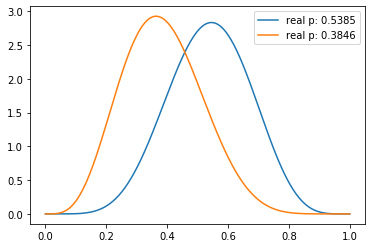

number of sample : 50


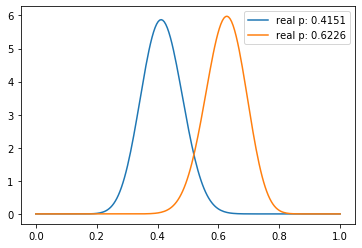

number of sample : 100


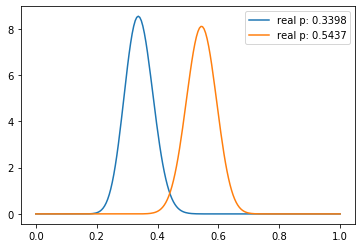

number of sample : 1000


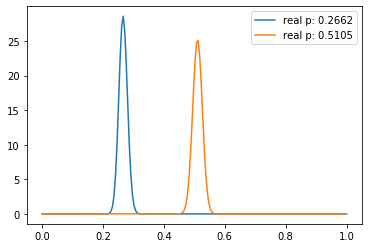

percent of times that Validation wins :  100.0
basket_count  Check:
Is Validation Set of  basket_count Conversion Rate is bigger than Control set?
number of sample : 10


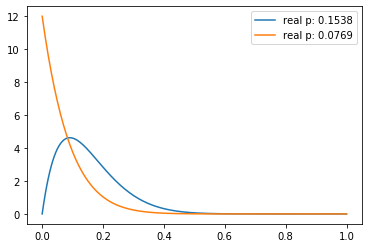

number of sample : 50


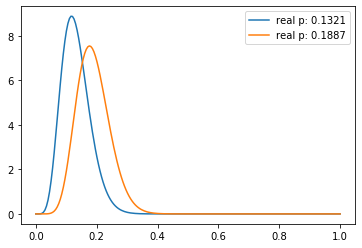

number of sample : 100


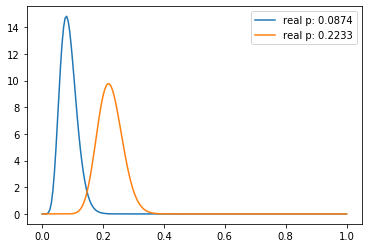

number of sample : 1000


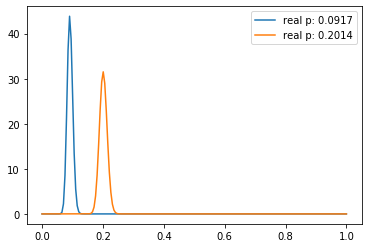

percent of times that Validation wins :  100.0
order_screen_count  Check:
Is Validation Set of  order_screen_count Conversion Rate is bigger than Control set?
number of sample : 10


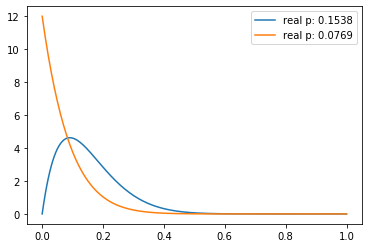

number of sample : 50


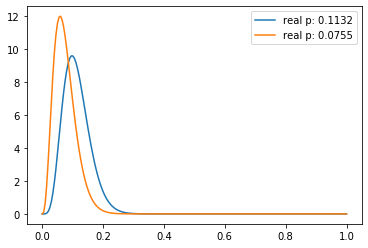

number of sample : 100


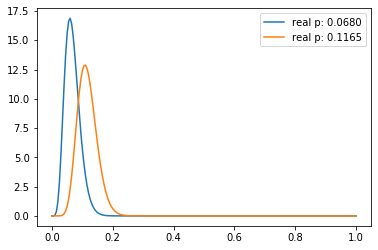

number of sample : 1000


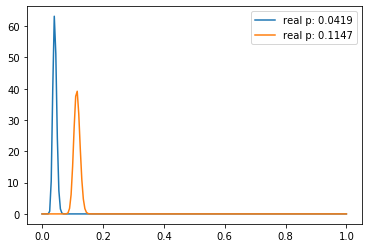

percent of times that Validation wins :  100.0
order_count  Check:
Is Validation Set of  order_count Conversion Rate is bigger than Control set?
number of sample : 10


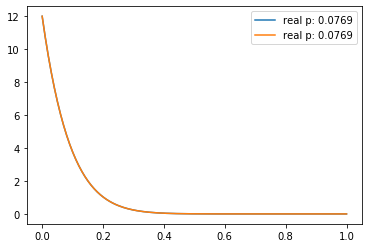

number of sample : 50


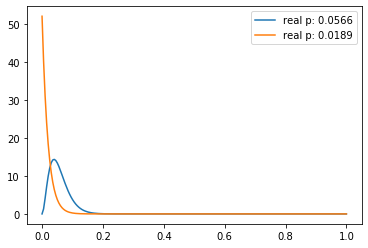

number of sample : 100


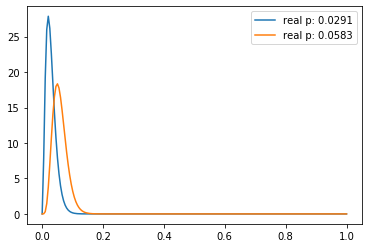

number of sample : 1000


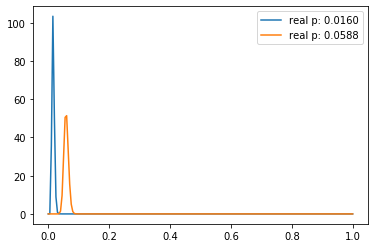

percent of times that Validation wins :  100.0


In [16]:
metrics = ['login_count', 'basket_count', 'order_screen_count', 'order_count']
control = ab_test[ab_test['is_control'] == 0]
validation = ab_test[ab_test['is_control'] == 1]

def plot_p_value(x, y1, y2, p1, p2):
    plt.plot(x, y1, label="real p: %.4f" % p1)
    plt.plot(x, y2, label="real p: %.4f" % p2)
    plt.legend()
    plt.show()

# check each metrics 
for metric in metrics:
    print(metric, " Check:")
    print("Is Validation Set of ", metric, "Conversion Rate is bigger than Control set?")

    x = np.linspace(0, 1, 200) # this is for ploting the results
    a_control, b_control = 1, 1 # at first we started we can assign beta a, b shape parameters defult 1 and 1.
    a_val, b_val = 1, 1 # it must be two beta distribution that is why I assing for each validaiton and control set of a and b.
    c_val, v_val = list(control[metric]), list(validation[metric])
    for ind in list(range(max(len(control), len(validation)))):
        # control set a, b updating
        # for each click update a and b paramters. a = click, b = non click
        try:
            a_control += c_val[ind] # click
            b_control += abs(c_val[ind] - 1) # non-click
        except:
            if ind + 1 == len(control):
                print("out of index")
        
        # validation set a, b updating
        try:
            a_val += v_val[ind] # click
            b_val += abs(v_val[ind] - 1) # non-click
        except:
            if ind + 1 == len(validation):
                print("out of index")
                
    
        if ind in [10, 50, 100, 1000]: # check for given indexes to make sure it is updating CTR parameter.
            print("number of sample :", ind)
            y_control = beta.pdf(x, a_control, b_control)  # beta probabilty density function for control a, b parameter
            y_validation = beta.pdf(x, a_val, b_val) # beta probabilty density function for  validation a, b parameter
            plot_p_value(x, y_control, y_validation, a_control / (a_control + b_control), a_val / (a_val + b_val))
            
    # check how many times vaidation CTR wins, control CTR
    control_p_values = stats.beta.rvs(a_control, b_control, size=len(control))
    validation_p_values = stats.beta.rvs(a_val, b_val, size=len(control))      
    wins = validation_p_values > control_p_values
    # ratio of wins: It also represents how accuratelly Validation Set has bigger CTR than Control Set.  
    print("percent of times that Validation wins : ", np.mean(wins) * 100) 


    
                       

# Result of Bayesian Approach:
- It is better with unkown parameter at the end it finalize with estimated parameter with Beta Distribution.


# Let`s run whole A/B Test for each days and check the results

In [17]:
# This function allows me to calculate the sample sizes, clieck count of each metrics
def get_metrics(df, metric, day, rfm):
    print("H0 : There is no difference on control and validation test sets on ", metric, " ratios.")
    print("p_control_", metric, " = ", "p_validation_", metric)
    print("H1: Thre statistically difference between Control And Validation sets ", metric, " ratios.")
    print("p_control_", metric, " != ", "p_validation_", metric)
    print(day)
    df_1 = df[df['day'] <= day]
    df_1 = df_1 if rfm is None else df_1[df_1['rfm'] == rfm]
    click1 =  sum(list(df_1[df_1['is_control'] == 0][metric]))
    click2 =  sum(list(df_1[df_1['is_control'] == 1][metric]))
    n1 = len(df_1[df_1['is_control'] == 0])
    n2 = len(df_1[df_1['is_control'] == 1])
    return click1, click2, n1, n2, list(df_1[df_1['is_control'] == 0][metric]), list(df_1[df_1['is_control'] == 1][metric])

In [18]:
# this function calculates t value, and confidence intervl of each metric
def definition_of_t_test(click1, click2, n1, n2):   
    pval, confidence_intervals = calculate_t_test(click1 / n1, click2 / n2, click1, click2, n1, n2)
    print(1 - pval, click1 / n1, click2 / n2, "HO REJECTED!" if 1 - pval > 0.975 or 1 - pval < 0.25 else "HO ACCEPTED!")
    return [1 - pval, "HO REJECTED!" if 1 - pval > 0.975 or 1 - pval < 0.25 else "HO ACCEPTED!", confidence_intervals]

In [19]:
# bayesian method of function to calculate probability of X data given of parameter
def bayesian_approach(c_val, v_val):
    
    def plot_p_value(x, y1, y2, p1, p2):
        plt.plot(x, y1, label="control p: %.4f" % p1)
        plt.plot(x, y2, label="validation p: %.4f" % p2)
        plt.legend()
        plt.show()
    

    x = np.linspace(0, 1, 200)
    a_control, b_control = 1, 1
    a_val, b_val = 1, 1
    number_of_sample = max(len(c_val), len(v_val))
    for ind in list(range(max(len(c_val), len(v_val)))):
        # control set a, b updating
        try:
            a_control += c_val[ind] # click
            b_control += abs(c_val[ind] - 1) # non-click
        except:
            if ind + 1 == len(c_val):
                print("out of index")
        
        # validation set a, b updating
        try:
            a_val += v_val[ind] # click
            b_val += abs(v_val[ind] - 1) # non-click
        except:
            if ind + 1 == len(v_val):
                print("out of index")
    
        if ind in [100, int((number_of_sample *3) / 4)]:
            print("number of sample :", ind)
            y_control = beta.pdf(x, a_control, b_control)
            y_validation = beta.pdf(x, a_val, b_val)
            plot_p_value(x, y_control, y_validation, a_control / (a_control + b_control), a_val / (a_val + b_val))
            
    control_p_values = stats.beta.rvs(a_control, b_control, size=len(c_val))
    validation_p_values = stats.beta.rvs(a_val, b_val, size=len(v_val))  
    sample_size = min(len(control_p_values), len(validation_p_values))
    wins = validation_p_values[:sample_size] > control_p_values[:sample_size]
    return  np.mean(wins)

In [20]:
# this functions to merge all outputs into one arrary to finalized
def test_control_validation_sets(ab_test_total, metric, day, rfm):
    click_control, click_vald, n_control, n_vald, _control, _validation = get_metrics(ab_test_total, metric, day, rfm)
    print(click_control, click_vald, n_control, n_vald, day, metric)
    t_test_outputs = definition_of_t_test(click_control, click_vald, n_control, n_vald)
    print("chi squared check :")
    chi_square_test_outputs = chi_square_test(n_control, click_control, n_vald, click_vald)
    print("Bayesian approach :")
    wins = bayesian_approach(_control, _validation)
    print(str(round(wins, 3) * 100), " % times validation set of CTR is bigger than control set of CTR")
    return click_control / n_control, click_vald / n_vald, np.mean(wins) ,t_test_outputs, chi_square_test_outputs

In [21]:
metrics = ['login_count', 'basket_count', 'order_screen_count', 'order_count']

In [22]:
# make sure you are running with csv file.
if is_from_db:
    days = list(pd.read_sql("""SELECT date FROM designingtest GROUP BY date ORDER BY date ASC""", connection_abtestdb)['date'])
    query = """
            SELECT
                client_id,
                is_control,
                date as day,
                sum(CASE WHEN session IS NOT NULL THEN 1 ELSE 0 END) as session_count,
                sum(CASE WHEN login IS NOT NULL THEN 1 ELSE 0 END) as login_count,
                sum(CASE WHEN basket IS NOT NULL THEN 1 ELSE 0 END) as basket_count,
                sum(CASE WHEN order_screen IS NOT NULL THEN 1 ELSE 0 END) as order_screen_count,
                sum(CASE WHEN ordered IS NOT NULL THEN 1 ELSE 0 END) as order_count
            
            FROM designingtest WHERE date >= '{}' and date <= '{}'
            GROUP BY client_id, is_control, date
    """.format(str(min(days))[0:10], str(max(days))[0:10])
    ab_test_total = pd.read_sql(query, connection_abtestdb)
    ab_test_total = pd.merge(ab_test_total, segments, on='client_id', how='left')
    ab_test_total['rfm'] = ab_test_total.apply(lambda row: 
                                               str(row['recency_segment']) + '_' + 
                                               str(row['frequency_segment']) + '_' + str(row['monetary_segment']) ,axis=1)
    
    print(len(ab_test_total))
    rfm_segments = list(ab_test_total['rfm'].unique())
    ab_test_total.head(1)
else:
    try:
        ab_test_total = pd.read_csv('ab_test_data.csv')
        ab_test_total['day'] = ab_test_total['day'].apply(lambda x: datetime.datetime.strptime(str(x)[0:10], '%Y-%m-%d'))
        days = list(ab_test_total['day'].unique())
        rfm_segments = list(ab_test_total['rfm'].unique())
    except:
        print("please check file has been unziped.")
        print("please check ab_test_data.csv is at same directory with .ipynb notebook.")

# it will take for a while, approximatelly  7 mins

 day : 2019-08-07
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
8201 11806 24723 26670 2019-08-07T00:00:00.000000000 login_count
0.9983970627276952 0.3317154067063059 0.44266966629171356 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


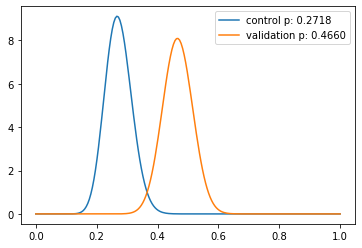

number of sample : 20002


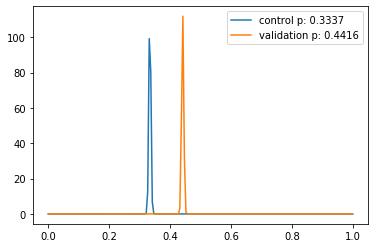

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 1_1_4
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
4675 6595 14494 14561 2019-08-07T00:00:00.000000000 login_count
0.997495146148126 0.3225472609355595 0.452922189410068 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


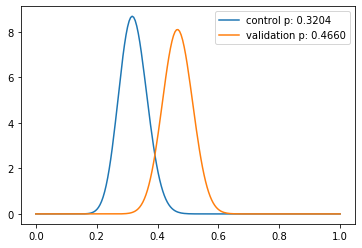

number of sample : 10920


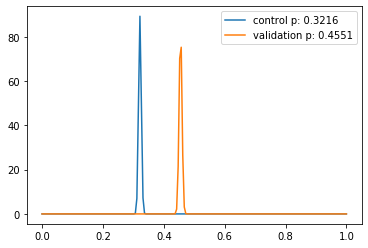

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_1_4
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
498 778 1652 1590 2019-08-07T00:00:00.000000000 login_count
0.9892225543777722 0.30145278450363194 0.48930817610062893 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


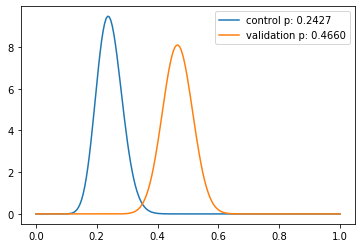

number of sample : 1239


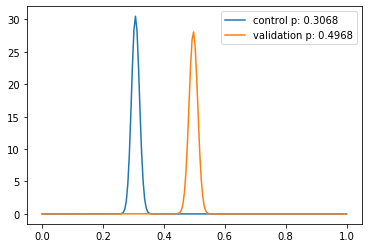

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_1_3
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
2000 2150 5321 5348 2019-08-07T00:00:00.000000000 login_count
0.9991713248061203 0.3758691975192633 0.40201944652206434 HO REJECTED!
chi squared check :
0.9971286894083063 HO REJECTED!
Bayesian approach :
number of sample : 100


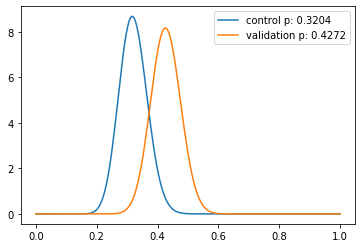

number of sample : 4011


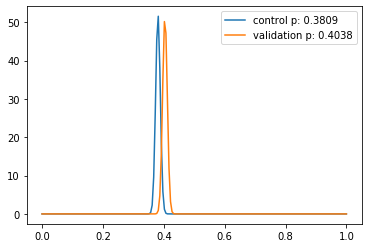

99.7  % times validation set of CTR is bigger than control set of CTR
rfm segment : 1_1_3
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
101 123 310 289 2019-08-07T00:00:00.000000000 login_count
0.9865496076172742 0.3258064516129032 0.42560553633217996 HO REJECTED!
chi squared check :
0.9341254109346699 HO ACCEPTED!
Bayesian approach :
number of sample : 100


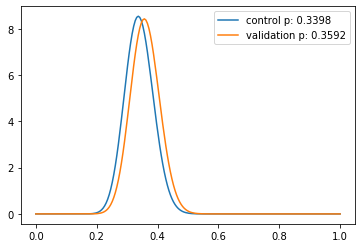

number of sample : 232


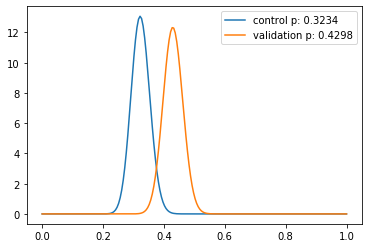

97.89999999999999  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_1_2
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
264 778 710 1834 2019-08-07T00:00:00.000000000 login_count
0.9962439972208721 0.37183098591549296 0.42420937840785167 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


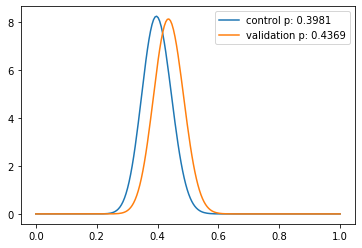

number of sample : 1375


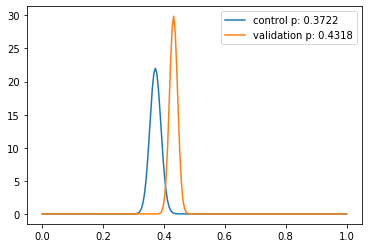

98.9  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_2_2
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
124 478 493 1012 2019-08-07T00:00:00.000000000 login_count
0.9802533922041267 0.2515212981744422 0.4723320158102767 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


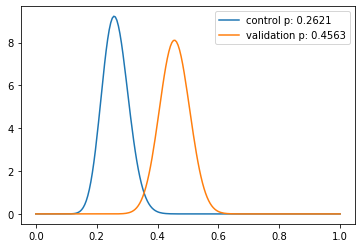

number of sample : 759


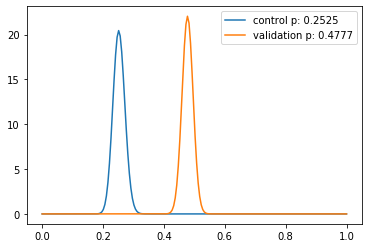

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_2_3
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
41 44 97 104 2019-08-07T00:00:00.000000000 login_count
0.9999097177287033 0.422680412371134 0.4230769230769231 HO REJECTED!
chi squared check :
0.33579115836504875 HO ACCEPTED!
Bayesian approach :
number of sample : 78


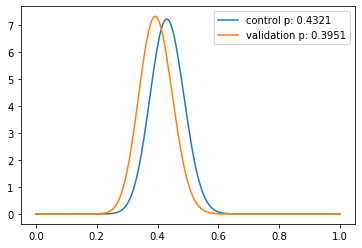

number of sample : 100


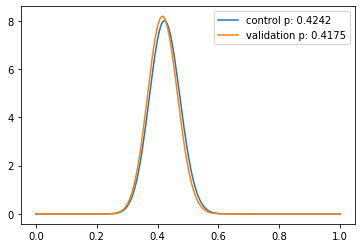

53.6  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_2_3
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
2 3 6 14 2019-08-07T00:00:00.000000000 login_count
0.8947713832644885 0.3333333333333333 0.21428571428571427 HO ACCEPTED!
chi squared check :
0.4418153505773427 HO ACCEPTED!
Bayesian approach :
number of sample : 10


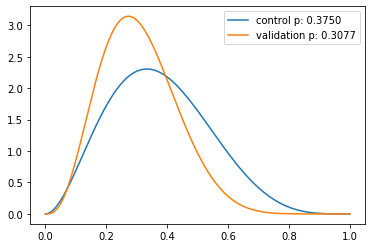

0.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_2_2
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
84 208 386 386 2019-08-07T00:00:00.000000000 login_count
0.9619814736938891 0.21761658031088082 0.538860103626943 HO ACCEPTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


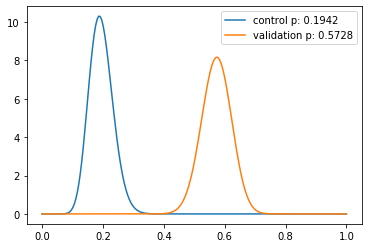

number of sample : 289


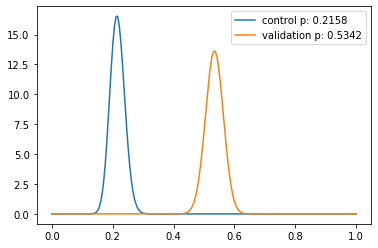

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_1_3
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
0 0 3 0 2019-08-07T00:00:00.000000000 login_count
not enough sample to test!
rfm segment : 3_1_2
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
1 8 17 13 2019-08-07T00:00:00.000000000 login_count
0.6579756852948622 0.058823529411764705 0.6153846153846154 HO ACCEPTED!
chi squared check :
0.9934937066817996 HO REJECTED!


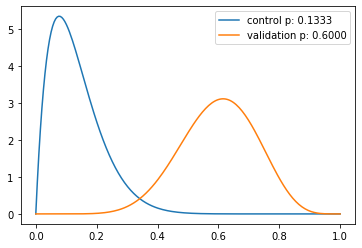

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_3_2
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
98 166 334 335 2019-08-07T00:00:00.000000000 login_count
0.9745021621456154 0.2934131736526946 0.4955223880597015 HO ACCEPTED!
chi squared check :
0.9999999261381617 HO REJECTED!
Bayesian approach :
number of sample : 100


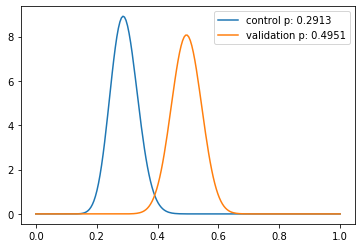

number of sample : 251


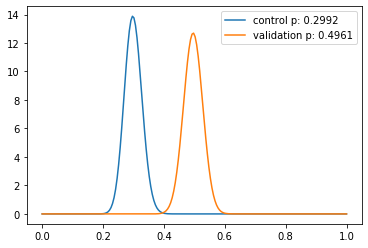

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_3_1
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
67 188 246 488 2019-08-07T00:00:00.000000000 login_count
0.9852142258078831 0.27235772357723576 0.38524590163934425 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


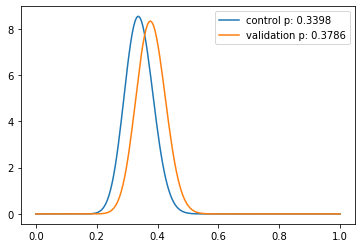

number of sample : 366


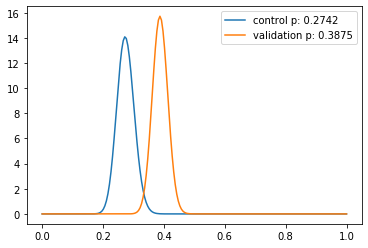

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_2_1
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
16 50 59 105 2019-08-07T00:00:00.000000000 login_count
0.9458553502829166 0.2711864406779661 0.47619047619047616 HO ACCEPTED!
chi squared check :
0.9999999997107559 HO REJECTED!
Bayesian approach :
number of sample : 78


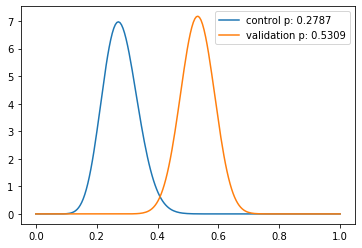

number of sample : 100


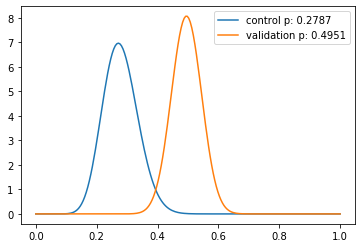

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_4_1
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
86 113 243 242 2019-08-07T00:00:00.000000000 login_count
0.9833589794509492 0.35390946502057613 0.4669421487603306 HO REJECTED!
chi squared check :
0.9872493859216679 HO REJECTED!
Bayesian approach :
number of sample : 100


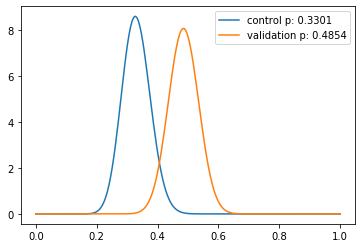

number of sample : 182


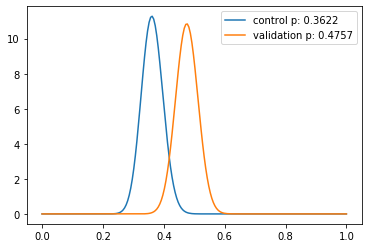

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_4_2
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
2 0 9 6 2019-08-07T00:00:00.000000000 login_count
0.7359494607295385 0.2222222222222222 0.0 HO ACCEPTED!
chi squared check :
0.8663855974622842 HO ACCEPTED!
Bayesian approach :
number of sample : 6


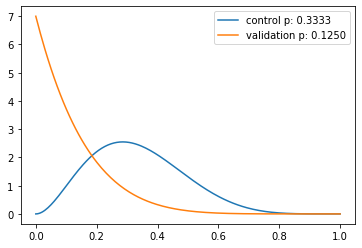

0.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 4_4_1
H0 : There is no difference on control and validation test sets on  login_count  ratios.
p_control_ login_count  =  p_validation_ login_count
H1: Thre statistically difference between Control And Validation sets  login_count  ratios.
p_control_ login_count  !=  p_validation_ login_count
2019-08-07T00:00:00.000000000
142 124 343 343 2019-08-07T00:00:00.000000000 login_count
0.9934403389357473 0.4139941690962099 0.36151603498542273 HO REJECTED!
chi squared check :
0.8416040788268081 HO ACCEPTED!
Bayesian approach :
number of sample : 100


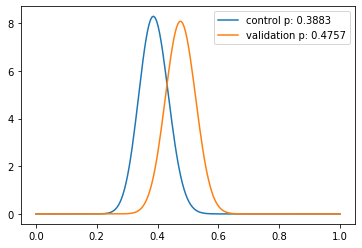

number of sample : 257


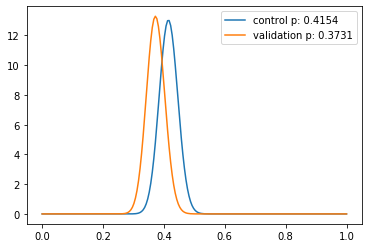

7.000000000000001  % times validation set of CTR is bigger than control set of CTR
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
2244 5250 24723 26670 2019-08-07T00:00:00.000000000 basket_count
0.9978826144905342 0.09076568377624075 0.1968503937007874 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


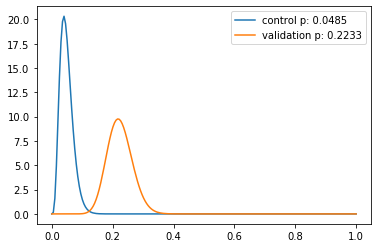

number of sample : 20002


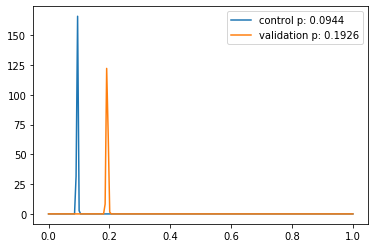

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 1_1_4
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
1069 3037 14494 14561 2019-08-07T00:00:00.000000000 basket_count
0.9963768826195816 0.07375465709948945 0.20857083991484102 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


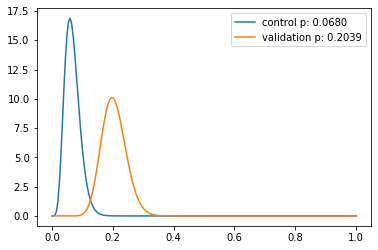

number of sample : 10920


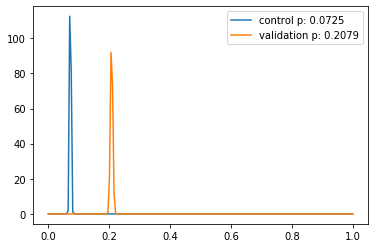

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_1_4
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
110 413 1652 1590 2019-08-07T00:00:00.000000000 basket_count
0.9852814460773194 0.06658595641646489 0.259748427672956 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


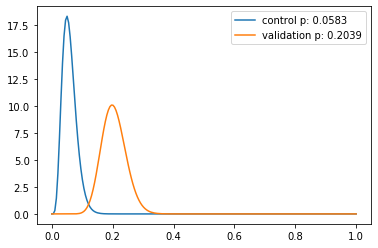

number of sample : 1239


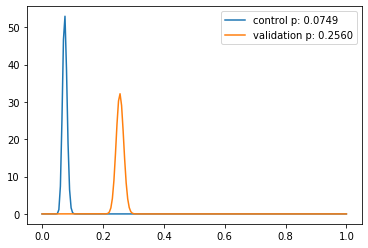

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_1_3
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
767 893 5321 5348 2019-08-07T00:00:00.000000000 basket_count
0.999026841404068 0.14414583724863747 0.16697830964846672 HO REJECTED!
chi squared check :
0.9992379218356888 HO REJECTED!
Bayesian approach :
number of sample : 100


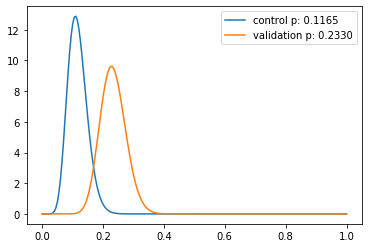

number of sample : 4011


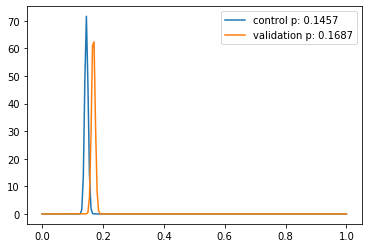

99.9  % times validation set of CTR is bigger than control set of CTR
rfm segment : 1_1_3
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
33 56 310 289 2019-08-07T00:00:00.000000000 basket_count
0.9839906703720491 0.1064516129032258 0.19377162629757785 HO REJECTED!
chi squared check :
0.9915713419446849 HO REJECTED!
Bayesian approach :
number of sample : 100


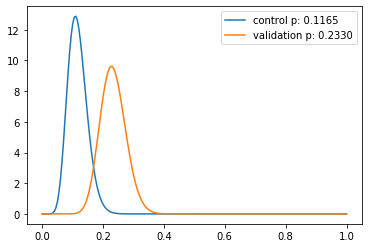

number of sample : 232


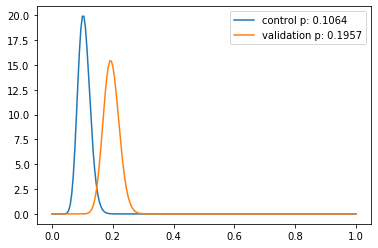

99.3  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_1_2
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
90 319 710 1834 2019-08-07T00:00:00.000000000 basket_count
0.9954709816734577 0.1267605633802817 0.17393675027262814 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


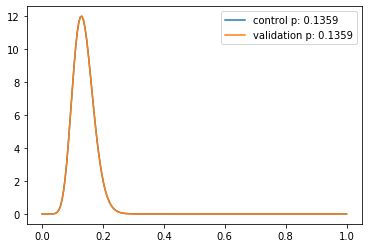

number of sample : 1375


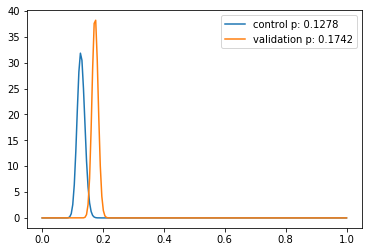

99.9  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_2_2
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
39 190 493 1012 2019-08-07T00:00:00.000000000 basket_count
0.9867479315472992 0.07910750507099391 0.18774703557312253 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


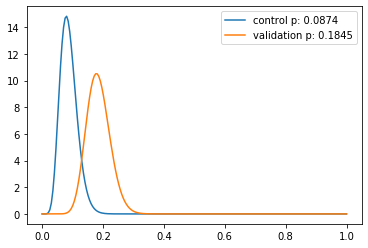

number of sample : 759


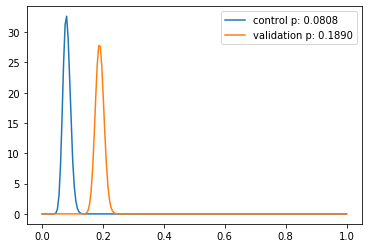

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_2_3
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
9 15 97 104 2019-08-07T00:00:00.000000000 basket_count
0.982154876333063 0.09278350515463918 0.14423076923076922 HO REJECTED!
chi squared check :
0.8092434310639962 HO ACCEPTED!
Bayesian approach :
number of sample : 78


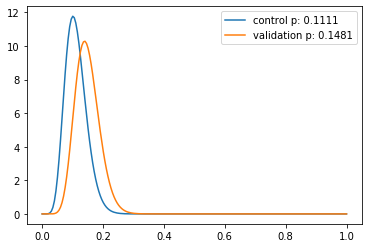

number of sample : 100


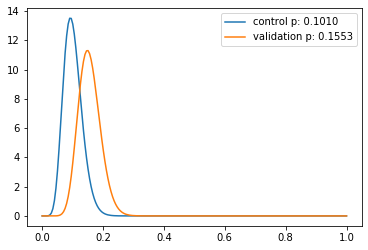

86.6  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_2_3
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
1 2 6 14 2019-08-07T00:00:00.000000000 basket_count
0.9744022742500382 0.16666666666666666 0.14285714285714285 HO ACCEPTED!
chi squared check :
0.4950149249061543 HO ACCEPTED!
Bayesian approach :
number of sample : 10


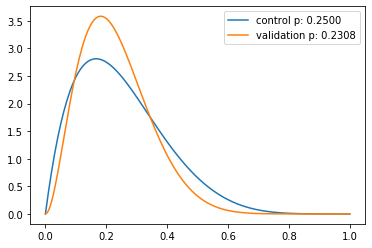

33.300000000000004  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_2_2
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
25 76 386 386 2019-08-07T00:00:00.000000000 basket_count
0.9775073316017205 0.06476683937823834 0.19689119170984457 HO REJECTED!
chi squared check :
0.9999999476776965 HO REJECTED!
Bayesian approach :
number of sample : 100


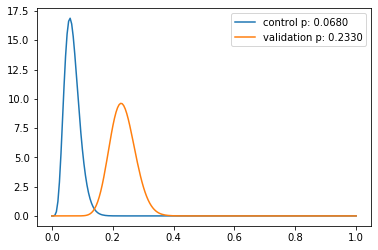

number of sample : 289


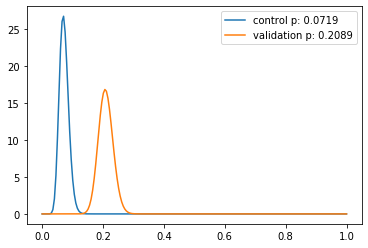

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_1_3
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
0 0 3 0 2019-08-07T00:00:00.000000000 basket_count
not enough sample to test!
rfm segment : 3_1_2
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
0 4 17 13 2019-08-07T00:00:00.000000000 basket_count
0.7412473554203545 0.0 0.3076923076923077 HO ACCEPTED!
chi squared check :
0.9667591891372059 HO REJECTED!
Bay

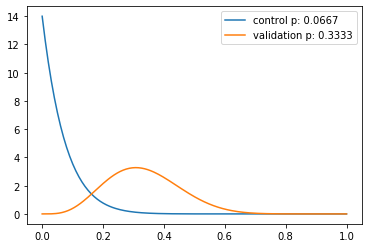

92.30000000000001  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_3_2
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
28 58 334 335 2019-08-07T00:00:00.000000000 basket_count
0.983546146862553 0.08383233532934131 0.17313432835820897 HO REJECTED!
chi squared check :
0.9994712694152282 HO REJECTED!
Bayesian approach :
number of sample : 100


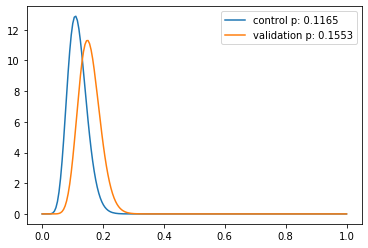

number of sample : 251


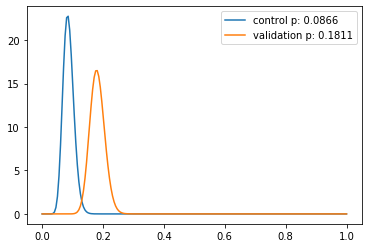

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_3_1
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
18 73 246 488 2019-08-07T00:00:00.000000000 basket_count
0.985538539444521 0.07317073170731707 0.14959016393442623 HO REJECTED!
chi squared check :
0.9999999998301022 HO REJECTED!
Bayesian approach :
number of sample : 100


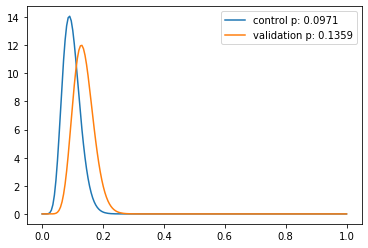

number of sample : 366


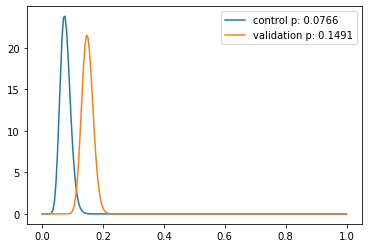

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_2_1
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
2 12 59 105 2019-08-07T00:00:00.000000000 basket_count
0.9627236128889833 0.03389830508474576 0.11428571428571428 HO ACCEPTED!
chi squared check :
0.9955841956892006 HO REJECTED!
Bayesian approach :
number of sample : 78


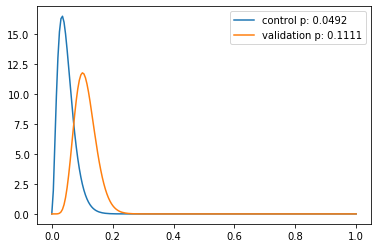

number of sample : 100


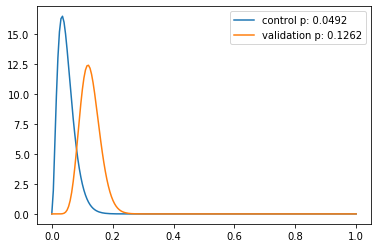

98.3  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_4_1
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
27 39 243 242 2019-08-07T00:00:00.000000000 basket_count
0.9894295382549273 0.1111111111111111 0.16115702479338842 HO REJECTED!
chi squared check :
0.8879221528750225 HO ACCEPTED!
Bayesian approach :
number of sample : 100


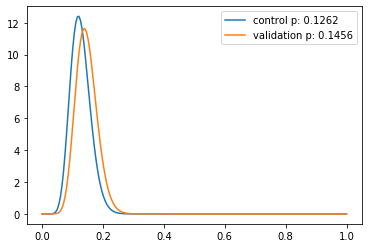

number of sample : 182


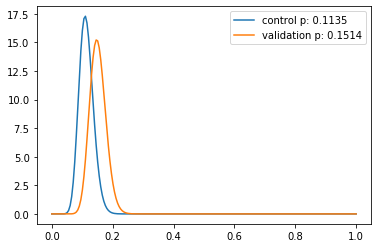

93.8  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_4_2
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
1 0 9 6 2019-08-07T00:00:00.000000000 basket_count
0.8180483231126251 0.1111111111111111 0.0 HO ACCEPTED!
chi squared check :
0.6965163359751579 HO ACCEPTED!
Bayesian approach :
number of sample : 6


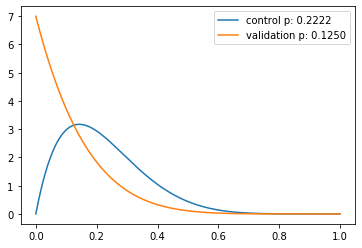

50.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 4_4_1
H0 : There is no difference on control and validation test sets on  basket_count  ratios.
p_control_ basket_count  =  p_validation_ basket_count
H1: Thre statistically difference between Control And Validation sets  basket_count  ratios.
p_control_ basket_count  !=  p_validation_ basket_count
2019-08-07T00:00:00.000000000
25 63 343 343 2019-08-07T00:00:00.000000000 basket_count
0.9798244891589802 0.0728862973760933 0.1836734693877551 HO REJECTED!
chi squared check :
0.9999856633575743 HO REJECTED!
Bayesian approach :
number of sample : 100


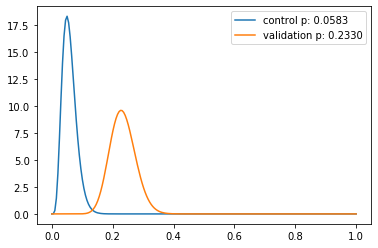

number of sample : 257


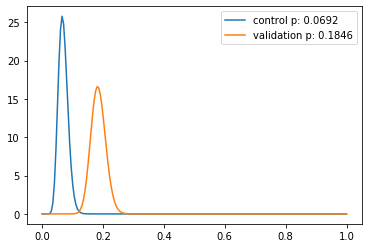

100.0  % times validation set of CTR is bigger than control set of CTR
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
952 2439 24723 26670 2019-08-07T00:00:00.000000000 order_screen_count
0.9984976948828356 0.03850665372325365 0.09145106861642295 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


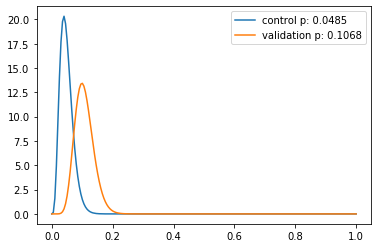

number of sample : 20002


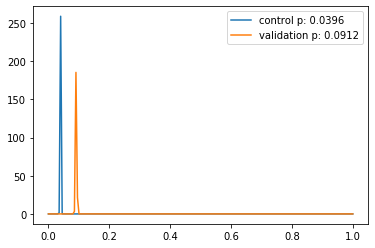

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 1_1_4
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
470 1351 14494 14561 2019-08-07T00:00:00.000000000 order_screen_count
0.9976688029610659 0.032427211259831654 0.09278208914222924 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


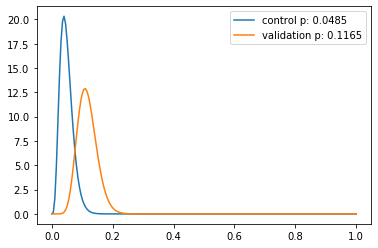

number of sample : 10920


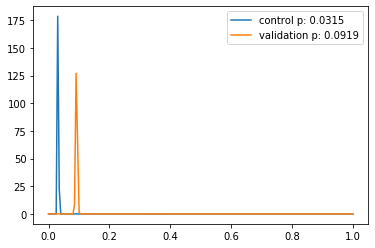

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_1_4
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
52 227 1652 1590 2019-08-07T00:00:00.000000000 order_screen_count
0.9888776184660786 0.031476997578692496 0.14276729559748427 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


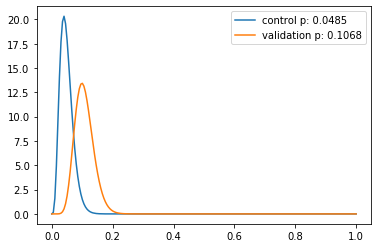

number of sample : 1239


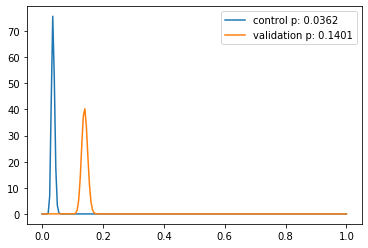

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_1_3
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
328 439 5321 5348 2019-08-07T00:00:00.000000000 order_screen_count
0.998777259742093 0.06164254839315918 0.08208676140613314 HO REJECTED!
chi squared check :
0.9999682752577372 HO REJECTED!
Bayesian approach :
number of sample : 100


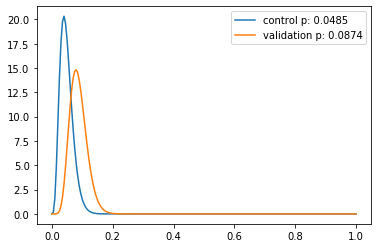

number of sample : 4011


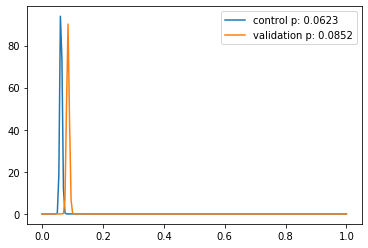

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 1_1_3
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
10 28 310 289 2019-08-07T00:00:00.000000000 order_screen_count
0.9827105816537682 0.03225806451612903 0.09688581314878893 HO REJECTED!
chi squared check :
0.9974200589843453 HO REJECTED!
Bayesian approach :
number of sample : 100


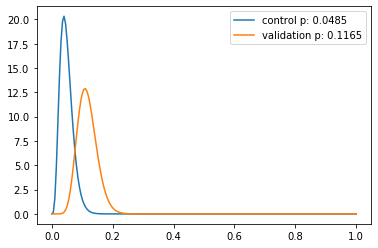

number of sample : 232


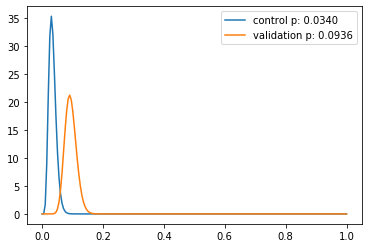

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_1_2
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
40 150 710 1834 2019-08-07T00:00:00.000000000 order_screen_count
0.9965860462098708 0.056338028169014086 0.08178844056706652 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


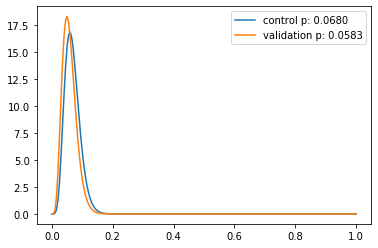

number of sample : 1375


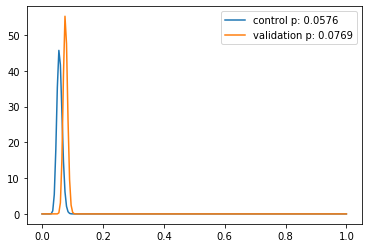

97.7  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_2_2
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
12 83 493 1012 2019-08-07T00:00:00.000000000 order_screen_count
0.9896088620685417 0.02434077079107505 0.08201581027667984 HO REJECTED!
chi squared check :
0.9999999999999818 HO REJECTED!
Bayesian approach :
number of sample : 100


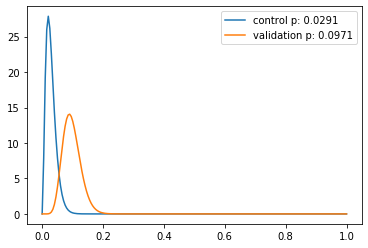

number of sample : 759


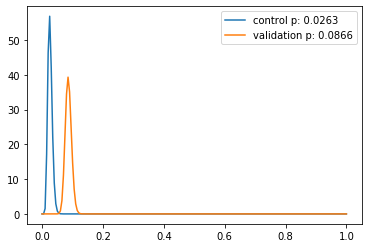

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 2_2_3
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
1 7 97 104 2019-08-07T00:00:00.000000000 order_screen_count
0.9672129806287433 0.010309278350515464 0.0673076923076923 HO ACCEPTED!
chi squared check :
0.9697239371040769 HO REJECTED!
Bayesian approach :
number of sample : 78


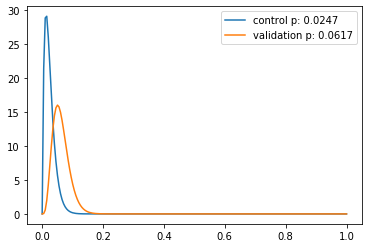

number of sample : 100


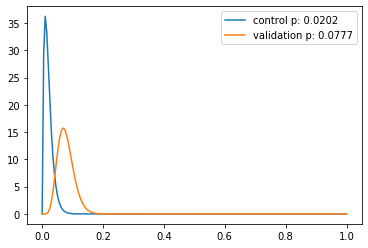

96.89999999999999  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_2_3
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
0 0 6 14 2019-08-07T00:00:00.000000000 order_screen_count
not enough sample to test!
rfm segment : 3_2_2
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
10 41 386 386 2019-08-07T00:00:00.000000000 order_screen_count
0.9814381

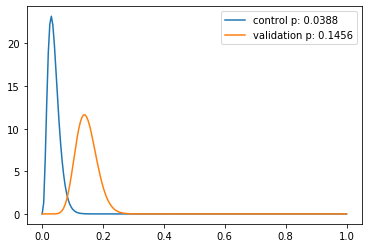

number of sample : 289


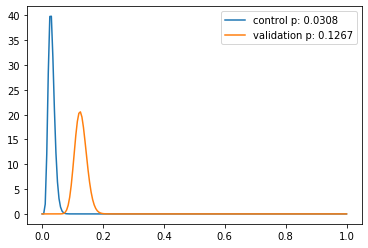

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_1_3
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
0 0 3 0 2019-08-07T00:00:00.000000000 order_screen_count
not enough sample to test!
rfm segment : 3_1_2
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
0 4 17 13 2019-08-07T00:00:00.000000000 order_screen_count
0.7412473554203545 0.0 0.3

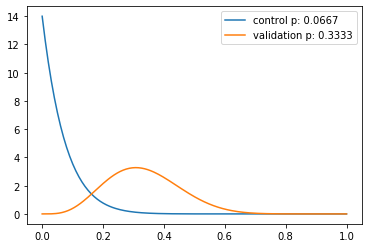

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_3_2
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
7 29 334 335 2019-08-07T00:00:00.000000000 order_screen_count
0.9820693916242487 0.020958083832335328 0.08656716417910448 HO REJECTED!
chi squared check :
0.9998365238949579 HO REJECTED!
Bayesian approach :
number of sample : 100


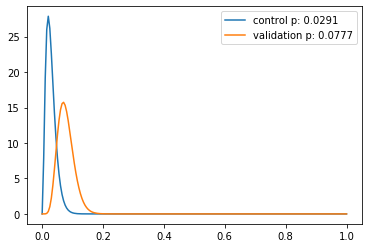

number of sample : 251


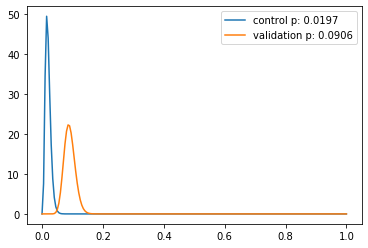

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_3_1
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
2 25 246 488 2019-08-07T00:00:00.000000000 order_screen_count
0.9857204331055714 0.008130081300813009 0.05122950819672131 HO REJECTED!
chi squared check :
0.9999947125269928 HO REJECTED!
Bayesian approach :
number of sample : 100


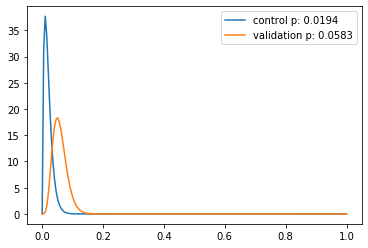

number of sample : 366


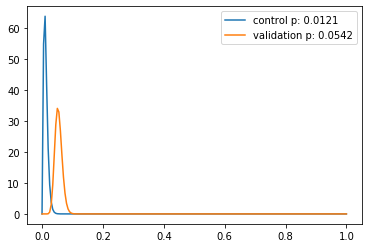

100.0  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_2_1
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
1 3 59 105 2019-08-07T00:00:00.000000000 order_screen_count
0.9902342583894748 0.01694915254237288 0.02857142857142857 HO REJECTED!
chi squared check :
0.6910333030211379 HO ACCEPTED!
Bayesian approach :
number of sample : 78


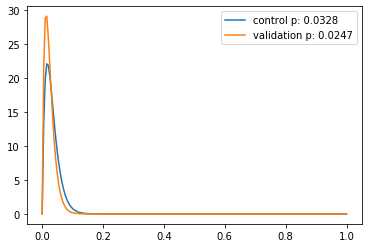

number of sample : 100


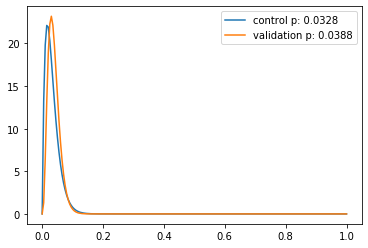

62.7  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_4_1
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
12 21 243 242 2019-08-07T00:00:00.000000000 order_screen_count
0.989245721702469 0.04938271604938271 0.08677685950413223 HO REJECTED!
chi squared check :
0.8953595033783568 HO ACCEPTED!
Bayesian approach :
number of sample : 100


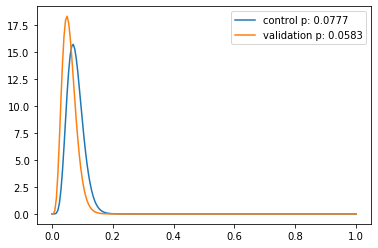

number of sample : 182


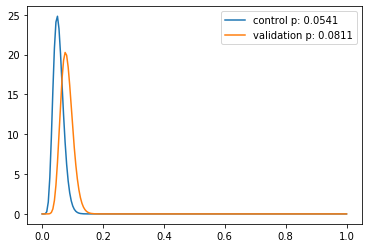

95.89999999999999  % times validation set of CTR is bigger than control set of CTR
rfm segment : 3_4_2
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
0 0 9 6 2019-08-07T00:00:00.000000000 order_screen_count
not enough sample to test!
rfm segment : 4_4_1
H0 : There is no difference on control and validation test sets on  order_screen_count  ratios.
p_control_ order_screen_count  =  p_validation_ order_screen_count
H1: Thre statistically difference between Control And Validation sets  order_screen_count  ratios.
p_control_ order_screen_count  !=  p_validation_ order_screen_count
2019-08-07T00:00:00.000000000
7 31 343 343 2019-08-07T00:00:00.000000000 order_screen_count
0.981371767

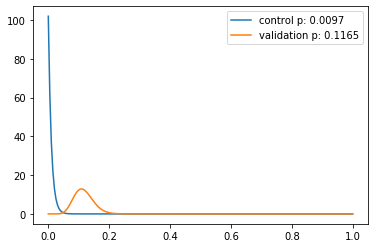

number of sample : 257


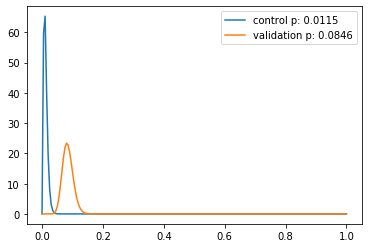

100.0  % times validation set of CTR is bigger than control set of CTR
H0 : There is no difference on control and validation test sets on  order_count  ratios.
p_control_ order_count  =  p_validation_ order_count
H1: Thre statistically difference between Control And Validation sets  order_count  ratios.
p_control_ order_count  !=  p_validation_ order_count
2019-08-07T00:00:00.000000000
354 1116 24723 26670 2019-08-07T00:00:00.000000000 order_count
0.9988367645431826 0.01431865064919306 0.04184476940382452 HO REJECTED!
chi squared check :
1.0 HO REJECTED!
Bayesian approach :
number of sample : 100


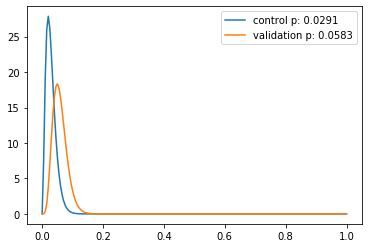

In [ ]:
df_list = df_list_rfm = []
p_value_contol = p_value_validation = win_list = []
for day in days:
    print(" day :", str(day)[0:10])
    for metric in metrics:        
        p_control, p_validation, win_ratio, t_test, chi_square = test_control_validation_sets(ab_test_total, metric, day, None)
        df_list.append({'p_control': p_control, 
                        'p_validation': p_validation, 
                        'win_ratio': win_ratio, 
                        't_test_p_value': t_test[0],
                        't_test_H0': t_test[1],
                        't_test_left_tail': t_test[2][0],
                        't_test_right_tail': t_test[2][1],
                        'chi_square_p_value': chi_square[0],
                        'chi_square_H0': chi_square[1],
                        'bayesian_approach_confidence': win_ratio,
                        'day': day,
                        'metrics': metric
                       })
        # check for each segment of Control and Validation Samples
        for rfm in rfm_segments:
            print("rfm segment :", rfm)
            try: # days there isn`t any transaction of some segments of clients
                p_control, p_validation, win_ratio, t_test, chi_square = test_control_validation_sets(ab_test_total, metric, day, 
                                                                                                       rfm)
                
                df_list_rfm.append({'p_control': p_control, 
                                    'p_validation': p_validation, 
                                    'win_ratio': win_ratio, 
                                    't_test_p_value': t_test[0],
                                    't_test_H0': t_test[1],
                                    't_test_left_tail': t_test[2][0],
                                    't_test_right_tail': t_test[2][1],
                                    'chi_square_p_value': chi_square[0],
                                    'chi_square_H0': chi_square[1],
                                    'bayesian_approach_confidence': win_ratio,
                                    'rfm': rfm,
                                    'day': day,
                                    'metrics': metric
                                   })
            except:
                print("not enough sample to test!")
            

In [ ]:
daily_ab_test_results = pd.DataFrame(df_list)
daily_ab_test_results_rfm = pd.DataFrame(df_list_rfm)

In [ ]:
daily_ab_test_results.to_csv('daily_ab_test_results.csv')
daily_ab_test_results_rfm.to_csv('daily_ab_test_results_rfm.csv')

# RESULTS

## Login CTR
- Variation Screen has an impact to clients of logins almost %80. O average It is 0.35 and jumps to on average 0.41.
- However, we concluded the test with 8241 and it improves only 500 of client on average. 
- This is a huge increase if we run on real time. For instance, if we have  10 milions vistors in each days, it would be 600k of increase in each days of vistores of logins from 3.5 million to 4.1 milion


## Basket CTR
- Variation Screen has an impact to clients of basket creating almost 60% on average. It is 0.12 and jumps to on average 0.18.
- However, we concluded the test with 8241 and it improves only 500 of client on average. 
- This is a huge increase if we run on real time. For instance, if we have  10 milions visitors in each days, it would be 600k of increase in each days of visitors of adding any item to basket count from 1.2 million to 1.8 milion


# Payment Screen CTR
- Variation Screen has an impact to clients of order screen clicks almost 38 % on average It is 0.05 and jumps to on average 0.08.
- However, we concluded the test with 8241 and it improves only 247 of client on average. 
- This is a huge increase if we run on real time. For instance, if we have 10 milions visitors in each days, it would be 300k of increase in each days of visitores of payment screen click count from 500k to 800k milion.
### It seems that when we continue our test enviroment this CTR values will close to each other more. That is why wee need to carry on data collecting for payment screen.

# Order CTR
- Variation Screen has an impact to clients of basket creating count almost 38% on average It is 0.05 and jumps to on average 0.08.
- However, we concluded the test with 8241 and it improves only 247 of client on average. 
- This is a huge increase if we run on real time. For instance, if we have 10 milions visitors in each days, it would be 300k of increase in each days of visitores of payment screen click count from 500k to 800k milion.
### This CTR values are also not well tested too. It must be more data in order to get the actual CTR improvements. Test must be continued for Order count CTR.

In [ ]:
visualization = daily_ab_test_results.pivot_table(index=['day', 'metrics'] , aggfunc={'p_control': 'mean', 
                                                                     'p_validation': 'mean'}).reset_index()

for metric in list(visualization['metrics'].unique()):
    print("metric :", metric)
    _df = visualization.query("metrics == @metric")
    x = [str(i)[0:10] for i in _df['day']]
    y = _df['p_control'].values
    plt.plot(x, y)
    y = _df['p_validation'].values
    plt.plot(x, y)
    plt.xticks(x, x, rotation='vertical')
    plt.show()

In [ ]:
date = list(visualization.sort_values(by = 'day', ascending=False)['day'])[5]
visualization['avg_diff_of_CTR'] = visualization['p_validation'] - visualization['p_control']
visualization_1 = visualization.query("day >= @date").pivot_table(index='metrics', 
                                                                  aggfunc={'avg_diff_of_CTR': 'mean'}).reset_index()
visualization_1['client_count'] = 10000000 * visualization_1['avg_diff_of_CTR']




In [ ]:
objects = list(visualization_1.metrics)
y_pos = np.arange(len(objects))
performance_1 = list(visualization_1.avg_diff_of_CTR)
plt.bar(y_pos, performance_1, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('CTR')
plt.title('Metrics of CTR Differences From Control to Validation')
plt.show()
objects = list(visualization_1.metrics)
y_pos = np.arange(len(objects))
performance_2 = list(visualization_1.client_count)
plt.bar(y_pos, performance_2, align='center', alpha=0.5)
plt.ylabel('client count difference After New Screen seen')
plt.title('What If This Company Has 10 millions of Visitors Daily')
plt.show()

# Segments of CTR Values

In [ ]:
visualization_2 = daily_ab_test_results_rfm.pivot_table(index=['day', 'metrics', 'rfm'] , aggfunc={'p_control': 'mean', 
                                                                                                    'p_validation': 'mean'}).reset_index()

for rfm in list(visualization_2['rfm'].unique()): 
    print(" segment :", rfm)
    for metric in list(visualization_2['metrics'].unique()):
        _df = visualization_2.query("metrics == @metric and rfm == @rfm")
        x = [str(i)[0:10] for i in _df['day']]
        y = _df['p_control'].values
        plt.plot(x, y, label= metric.split('_')[0] + ' c.' )
        y = _df['p_validation'].values
        plt.plot(x, y, label= metric.split('_')[0] + ' v.' )
        plt.grid(True)
        plt.xticks(x, x, rotation='vertical')
    plt.legend()
    plt.show()
    



### A/B Test Segment Explation:
- Segmentaion is created with the popular markettn client segmentation which is RFM (Recency - Frequency- Monetary)
- Recency: How frequently client is ordered.
- Frequency: How frequently client visits.
- Monetary: represents average of basket values of clients.
- Each metrics segmented into 4 groups. There are at most 4 *4 * = 64 group can be created. 1; represents the best, 4; the worst segment.
- Some segments need more data as like 3_1_3.
- 1_1_3, 2_2_2, 3_2_1, 3_2_2, 3_3_1, 3_3_2, 3_4_1 segmets are well has better impact pn validation sets.

In [ ]:
best_segments = ['1_1_3', '2_2_2', '3_2_1', '3_2_2', '3_3_1', '3_3_2', '3_4_1']
fequencies = pd.DataFrame([int(rfm.split('_')[0]) for rfm in best_segments]).rename(columns={0: 'frequency'})
fequencies['freq_count'] = fequencies['frequency']
fequencies = fequencies.pivot_table(index='frequency', aggfunc={'freq_count': 'count'}).reset_index()
recencies = pd.DataFrame([int(rfm.split('_')[1]) for rfm in best_segments]).rename(columns={0: 'recency'})
recencies['r_count'] = recencies['recency']
recencies = recencies.pivot_table(index='recency', aggfunc={'r_count': 'count'}).reset_index()
monetaries = pd.DataFrame([int(rfm.split('_')[2]) for rfm in best_segments]).rename(columns={0: 'monetary'})
monetaries['m_count'] = monetaries['monetary']
monetaries = monetaries.pivot_table(index='monetary', aggfunc={'m_count': 'count'}).reset_index()

In [ ]:
display(fequencies, recencies, monetaries)

### Results of segmented clients:
- The client who pays much loves the new screen :)
- However, these clients are not frequently vistors.

# For Next Analysis
- This segmented clients of attributtes must be investiged. 
- Are their frequency segments are changing?  
- What is their order period has change?

for more information pls check gitHub reporsitory:
https://github.com/caglanakpinar/a_b_test

# Dashboard to Visualization Outputs

- I use dash library to visualize outputs.
- Make sure you install dash library. Both conda install and pip install coments are worked on that.
- In addition to Dash library, you need to install plotly too.
- In order to use plotly library you need license. However, they allow us to use it locally offline 

In [ ]:
# check these libraries can be imported successfully
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

- run the code .ipynb notebook below.
- Make sure is at same directory as current file.
- Make sure 'daily_ab_test_results.csv' and 'daily_ab_test_results_rfm.csv' are in the same directory.
- If there aren`t any of these .csv file, you can use defaults

In [47]:
%run ./visualization.ipynb

path (if file in same directory pls assign '-'):

file name (if result file in same directory pls assign '-'):

Segment file name (if segment (RFM) result file in same directory pls assign '-'):

result file has been uploaded succesfully
result rfm file has been uploaded succesfully
 * Serving Flask app "visualization" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [17/Aug/2019 21:20:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:45] "GET /_dash-component-suites/dash_renderer/react@16.8.6.min.js?v=1.0.0&m=1565108264 HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:45] "GET /_dash-component-suites/dash_renderer/prop-types@15.7.2.min.js?v=1.0.0&m=1565108264 HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:45] "GET /_dash-component-suites/dash_renderer/react-dom@16.8.6.min.js?v=1.0.0&m=1565108264 HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:45] "GET /_dash-component-suites/dash_core_components/highlight.pack.js?v=1.1.0&m=1565108265 HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:45] "GET /_dash-component-suites/dash_html_components/dash_html_components.min.js?v=1.0.0&m=1565108265 HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:45] "GET /_dash-component-suites/dash_renderer/dash_renderer.min.js?v=1.0.0&m=1565108264 HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 2

ALL ALL ALL ALL ALL ALL
ALL ALL ALL ALL ALL ALL
16
      rfm  p_control  p_validation      diff
0   1_1_3   0.110577      0.197368  0.086791
1   1_1_4   0.063043      0.255778  0.192735
2   2_1_2   0.179592      0.187396  0.007804
3   2_1_3   0.192210      0.125900 -0.066310
4   2_1_4   0.099907      0.253327  0.153420
5   2_2_2   0.123476      0.131737  0.008261
6   2_2_3   0.204301      0.196078 -0.008223
7   3_1_2   0.000000      0.285714  0.285714
8   3_2_1   0.130435      0.151515  0.021080
9   3_2_2   0.058594      0.255725  0.197131
10  3_2_3   1.000000      0.312500 -0.687500
11  3_3_1   0.125000      0.106250 -0.018750
12  3_3_2   0.068182      0.256757  0.188575
13  3_4_1   0.126582      0.176471  0.049888
14  3_4_2   0.375000      0.000000 -0.375000
15  4_4_1   0.120614      0.188596  0.067982


127.0.0.1 - - [17/Aug/2019 21:20:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:55] "POST /_dash-update-component HTTP/1.1" 200 -


17
      rfm  p_control  p_validation      diff
0   1_1_3   0.131546      0.178481  0.046934
1   1_1_4   0.127848      0.185325  0.057477
2   2_1_2   0.137164      0.171889  0.034725
3   2_1_3   0.141135      0.167511  0.026376
4   2_1_4   0.138117      0.178368  0.040250
5   2_2_2   0.122875      0.175377  0.052502
6   2_2_3   0.129612      0.149362  0.019751
7   3_1_2   0.115979      0.199324  0.083345
8   3_1_3   0.150000      0.166667  0.016667
9   3_2_1   0.086093      0.139643  0.053551
10  3_2_2   0.126575      0.174381  0.047807
11  3_2_3   0.213235      0.181818 -0.031417
12  3_3_1   0.100527      0.177921  0.077394
13  3_3_2   0.112662      0.178451  0.065789
14  3_4_1   0.105894      0.191940  0.086047
15  3_4_2   0.103448      0.194915  0.091467
16  4_4_1   0.115870      0.177966  0.062096


127.0.0.1 - - [17/Aug/2019 21:20:56] "POST /_dash-update-component HTTP/1.1" 200 -


17
      rfm  p_control  p_validation      diff
0   1_1_3   0.132991      0.175389  0.042398
1   1_1_4   0.127615      0.185738  0.058123
2   2_1_2   0.138008      0.173400  0.035392
3   2_1_3   0.142055      0.166490  0.024435
4   2_1_4   0.140899      0.174976  0.034077
5   2_2_2   0.120558      0.179872  0.059313
6   2_2_3   0.132486      0.147845  0.015358
7   3_1_2   0.108173      0.196875  0.088702
8   3_1_3   0.150000      0.125000 -0.025000
9   3_2_1   0.083075      0.137460  0.054385
10  3_2_2   0.124599      0.174397  0.049798
11  3_2_3   0.198630      0.189024 -0.009606
12  3_3_1   0.104610      0.175784  0.071174
13  3_3_2   0.115058      0.176393  0.061334
14  3_4_1   0.108321      0.187275  0.078954
15  3_4_2   0.095238      0.218750  0.123512
16  4_4_1   0.113883      0.179141  0.065258
17


127.0.0.1 - - [17/Aug/2019 21:20:56] "POST /_dash-update-component HTTP/1.1" 200 -


      rfm  p_control  p_validation      diff
0   1_1_3   0.132141      0.174165  0.042024
1   1_1_4   0.129560      0.182358  0.052798
2   2_1_2   0.135906      0.173673  0.037767
3   2_1_3   0.139464      0.169799  0.030335
4   2_1_4   0.141818      0.172739  0.030921
5   2_2_2   0.119904      0.180537  0.060633
6   2_2_3   0.128413      0.148527  0.020114
7   3_1_2   0.103211      0.186782  0.083571
8   3_1_3   0.136364      0.125000 -0.011364
9   3_2_1   0.083333      0.141387  0.058054
10  3_2_2   0.122786      0.179274  0.056488
11  3_2_3   0.185185      0.191860  0.006675
12  3_3_1   0.105017      0.174894  0.069877
13  3_3_2   0.113226      0.176906  0.063679
14  3_4_1   0.106755      0.187924  0.081169
15  3_4_2   0.106061      0.223881  0.117820
16  4_4_1   0.110772      0.182734  0.071962


127.0.0.1 - - [17/Aug/2019 21:20:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:20:59] "POST /_dash-update-component HTTP/1.1" 200 -


17
      rfm  p_control  p_validation      diff
0   1_1_3   0.132979      0.179587  0.046608
1   1_1_4   0.129868      0.182316  0.052448
2   2_1_2   0.141578      0.170878  0.029299
3   2_1_3   0.144261      0.163864  0.019602
4   2_1_4   0.136870      0.181724  0.044854
5   2_2_2   0.120935      0.175329  0.054395
6   2_2_3   0.130390      0.151942  0.021552
7   3_1_2   0.113636      0.204861  0.091225
8   3_1_3   0.150000      0.000000 -0.150000
9   3_2_1   0.083916      0.144283  0.060367
10  3_2_2   0.126494      0.175105  0.048611
11  3_2_3   0.207692      0.195652 -0.012040
12  3_3_1   0.100605      0.181205  0.080600
13  3_3_2   0.116426      0.173841  0.057415
14  3_4_1   0.107114      0.191851  0.084737
15  3_4_2   0.105263      0.203704  0.098441
16  4_4_1   0.113503      0.180466  0.066963
17
      rfm  p_control  p_validation      diff
0   1_1_3   0.133345      0.180626  0.047281
1   1_1_4   0.129924      0.183277  0.053353
2   2_1_2   0.140294      0.166764  0.026470
3   

127.0.0.1 - - [17/Aug/2019 21:21:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:21:00] "POST /_dash-update-component HTTP/1.1" 200 -


17
      rfm  p_control  p_validation      diff
0   1_1_3   0.133257      0.181854  0.048596
1   1_1_4   0.134235      0.180875  0.046640
2   2_1_2   0.142397      0.164352  0.021955
3   2_1_3   0.144328      0.164988  0.020660
4   2_1_4   0.135954      0.183997  0.048043
5   2_2_2   0.116310      0.181468  0.065159
6   2_2_3   0.128842      0.156390  0.027549
7   3_1_2   0.118243      0.210317  0.092074
8   3_1_3   0.166667      0.000000 -0.166667
9   3_2_1   0.087090      0.148033  0.060943
10  3_2_2   0.125371      0.176822  0.051451
11  3_2_3   0.200000      0.185484 -0.014516
12  3_3_1   0.097197      0.182307  0.085110
13  3_3_2   0.116140      0.176531  0.060391
14  3_4_1   0.105706      0.194079  0.088373
15  3_4_2   0.088235      0.226190  0.137955
16  4_4_1   0.109005      0.185777  0.076772
17
      rfm  p_control  p_validation      diff
0   1_1_3   0.133197      0.183617  0.050420
1   1_1_4   0.127828      0.187093  0.059265
2   2_1_2   0.144596      0.166780  0.022185
3   

127.0.0.1 - - [17/Aug/2019 21:21:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:21:00] "POST /_dash-update-component HTTP/1.1" 200 -


17
      rfm  p_control  p_validation      diff
0   1_1_3   0.140777      0.180729  0.039952
1   1_1_4   0.129488      0.185234  0.055745
2   2_1_2   0.150021      0.156097  0.006075
3   2_1_3   0.151021      0.158027  0.007006
4   2_1_4   0.128467      0.188088  0.059621
5   2_2_2   0.118012      0.175317  0.057305
6   2_2_3   0.127709      0.155977  0.028268
7   3_1_2   0.129464      0.207447  0.077983
8   3_1_3   0.166667      0.000000 -0.166667
9   3_2_1   0.086022      0.157682  0.071660
10  3_2_2   0.122989      0.173047  0.050058
11  3_2_3   0.214286      0.193182 -0.021104
12  3_3_1   0.091566      0.181472  0.089906
13  3_3_2   0.115119      0.177876  0.062757
14  3_4_1   0.100782      0.197610  0.096828
15  3_4_2   0.078947      0.189655  0.110708
16  4_4_1   0.110649      0.184649  0.074001


127.0.0.1 - - [17/Aug/2019 21:21:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:21:04] "POST /_dash-update-component HTTP/1.1" 200 -


17
      rfm  p_control  p_validation      diff
0   1_1_3   0.133197      0.183617  0.050420
1   1_1_4   0.127828      0.187093  0.059265
2   2_1_2   0.144596      0.166780  0.022185
3   2_1_3   0.146580      0.163296  0.016715
4   2_1_4   0.134142      0.185724  0.051582
5   2_2_2   0.118631      0.176771  0.058140
6   2_2_3   0.133676      0.153148  0.019472
7   3_1_2   0.119403      0.208333  0.088930
8   3_1_3   0.166667      0.000000 -0.166667
9   3_2_1   0.085938      0.155269  0.069332
10  3_2_2   0.127649      0.172454  0.044804
11  3_2_3   0.200000      0.169643 -0.030357
12  3_3_1   0.097598      0.181409  0.083811
13  3_3_2   0.120229      0.170429  0.050200
14  3_4_1   0.110693      0.189037  0.078344
15  3_4_2   0.085106      0.192308  0.107201
16  4_4_1   0.109295      0.184862  0.075567
17
      rfm  p_control  p_validation      diff
0   1_1_3   0.139955      0.176772  0.036817
1   1_1_4   0.132337      0.181063  0.048727
2   2_1_2   0.147461      0.161266  0.013805
3   

127.0.0.1 - - [17/Aug/2019 21:21:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:21:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:21:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2019 21:21:07] "POST /_dash-update-component HTTP/1.1" 200 -
